## Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.cm as cm

## Funções

In [44]:
def preparar_planilha(caminho):
    #Importando a planilha
    dataframe = pd.read_csv(caminho)
    pd.set_option('display.float_format', '{:.2f}'.format) #Apresenta os dados com 2 casas decimais
    quantidadeDeNaN = dataframe.isna().sum() #Soma a quantidade de nulos em cada coluna da planilha
    dataframe = dataframe.drop(columns=['source', 'id_municipality'])
    print('Quantidade de linhas/colunas: ')
    print(dataframe.shape)
    print('\nColunas: ')
    print(dataframe.columns)
    print('\nQuantidade de NaN por coluna:')
    print(quantidadeDeNaN)
    print('\nExibição primeiras linhas: ')
    display(dataframe.head())
    
    return dataframe

In [45]:
def analise_descritiva(dataframe):
    #Estatisticas por ano
    estatistica_populacao_ano = dataframe.groupby('year')['population'].describe()
    moda = dataframe.groupby('year')['population'].agg(lambda x: x.mode().iloc[0])
    estatistica_populacao_ano['mode'] = moda
    
    print('Analise descritivas por ano:')
    display(estatistica_populacao_ano)

In [46]:
def agrupamento_por_regiao(estado):
    regioes_brasil = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PN', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'SP', 'RJ'],
    'Sul': ['PR', 'RS', 'SC'],
}
    
    for regiao, estados in regioes_brasil.items():
        if estado in estados:
            return regiao
    return None

In [47]:
def crescimento_estado(dataframe):

    df_estado = dataframe.groupby(['year', 'abbrev_state'])['population'].sum().unstack()

    # Calculando a população total para cada estado ao longo do tempo
    total_populacao_por_estado = df_estado.sum().sort_values(ascending=False)

    # Ordenando o DataFrame pelos estados com maior população
    df_state_sorted = df_estado[total_populacao_por_estado.index]

    # Plotando a evolução da população por estado, agora em ordem decrescente de população
    df_state_sorted.plot(kind='line', marker='.', figsize=(10, 6))

    # Personalizando o gráfico
    plt.title('Crescimento Populacional por Estado')
    plt.xlabel('Ano')
    plt.ylabel('População Total')

    # Formatando o eixo Y para exibir os valores em milhões
    formatter = mticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Adicionando uma grade
    plt.grid(True)

    # Movendo a legenda para fora do gráfico e ordenada do maior para o menor
    plt.legend(title="Estados", bbox_to_anchor=(1.05, 1), loc='upper left', labels=total_populacao_por_estado.index)

    # Ajustando o layout para a legenda
    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

In [48]:
def crescimento_regiao(dataframe):   
    dataframe['region'] = dataframe['abbrev_state'].apply(agrupamento_por_regiao)
    
    # Agrupando por região e somando a população total
    df_regiao = dataframe.groupby(['year', 'region'])['population'].sum().unstack()

    # Calculando a população total para cada região ao longo do tempo
    total_populacao_por_regiao = df_regiao.sum().sort_values(ascending=False)

    # Ordenando o DataFrame pelas regiões com maior população
    df_region_sorted = df_regiao[total_populacao_por_regiao.index]

    # Plotando a evolução da população por região, agora em ordem decrescente de população
    df_region_sorted.plot(kind='line', marker='o', figsize=(10, 6))

    # Personalizando o gráfico
    plt.title('Crescimento Populacional por Região')
    plt.xlabel('Ano')
    plt.ylabel('População Total')

    # Formatando o eixo Y para exibir os valores em milhões
    formatter = mticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Adicionando uma grade
    plt.grid(True)

    # Movendo a legenda para fora do gráfico e ordenada do maior para o menor
    plt.legend(title="Regiões", bbox_to_anchor=(1.05, 1), loc='upper left', labels=total_populacao_por_regiao.index)

    # Ajustando o layout para a legenda
    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

In [49]:
def calcular_z_score(dataframe):
    media = np.mean(dataframe['population'])
    desvio_padrao = np.std(dataframe['population'])
    z_scores = (dataframe['population'] - media) / desvio_padrao
    dataframe['z_score'] = z_scores
    outliers_z = dataframe[(dataframe['z_score'] < -3) | (dataframe['z_score'] > 3)]
    outliers_z = outliers_z.sort_values(by='z_score')
    cidades_outliers = outliers_z['name_municipality'].unique()
    quantidade_cidade_outliers = len(cidades_outliers)

    plt.figure(figsize=(12,6))
    sns.barplot(x=outliers_z['name_municipality'], y=outliers_z['z_score'], palette='coolwarm')

    plt.title(f'Z-Scores de Municípios Outliers (n={quantidade_cidade_outliers})', fontsize=16)
    plt.xlabel('Município', fontsize=12)
    plt.ylabel('Z-Score', fontsize=12)

    plt.xticks(rotation=90)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=3, color='red', linestyle='--', linewidth=1)

    plt.grid(True)
    plt.show()

In [50]:
def calcular_iqr(dataframe):
    q1 = np.percentile(dataframe['population'], 25)
    q3 = np.percentile(dataframe['population'], 75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    outliers_iqr = dataframe[(dataframe['population'] < limite_inferior) | (dataframe['population'] > limite_superior)]
    outliers_iqr = outliers_iqr.sort_values(by='population')

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=outliers_iqr.index, y=outliers_iqr['population'], hue=outliers_iqr['region'], palette='coolwarm')

    # Adicionar título e labels
    plt.title('Distribuição de Outliers de População por Município (Baseado no IQR)', fontsize=16)
    plt.xlabel('Índice do Município', fontsize=12)  # Simplesmente usar o índice do DataFrame no eixo X
    plt.ylabel('População', fontsize=12)

    # Remover os rótulos das cidades no eixo X para evitar sobrecarga visual
    plt.xticks([])  # Remove os labels do eixo X

    # Adicionar linhas de referência para os limites do IQR
    plt.axhline(y=limite_inferior, color='red', linestyle='--', linewidth=1, label='Limite Inferior')
    plt.axhline(y=limite_superior, color='red', linestyle='--', linewidth=1, label='Limite Superior')

    # Exibir a legenda e o gráfico
    plt.legend(title='Região')
    plt.grid(True)
    plt.show()

In [51]:
def media_regiao_e_estado(dataframe):
    media_populacao_regiao = dataframe.groupby('region')['population'].mean()
    media_populacao_estado = dataframe.groupby('abbrev_state')['population'].mean()

    plt.figure(figsize=(12,6))
    media_populacao_regiao.plot(kind='bar', color='skyblue')
    plt.title('Média populacional por Região', fontsize=16)
    plt.xlabel('Região', fontsize=12)
    plt.ylabel('Média populacional', fontsize=12)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,6))
    media_populacao_estado.plot(kind='bar', color='green')
    plt.title('Média populacional por estado', fontsize=16)
    plt.xlabel('Estados', fontsize=12)
    plt.ylabel('Média populacional', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x / 1e3)}K'))
    plt.grid(True)
    plt.show()

In [52]:
def proporcao_populacional_estado(dataframe):
    ano_especifico = 2022
    dataframe_ano_especifico = dataframe[dataframe['year'] == ano_especifico]

    populacao_total_ano = dataframe_ano_especifico['population'].sum()

    proporcao_populacao_estado = dataframe_ano_especifico.groupby('abbrev_state')['population'].sum() / populacao_total_ano

    proporcao_populacao_estado_sorted = proporcao_populacao_estado.sort_values(ascending=False)

    colors = cm.get_cmap('tab20', len(proporcao_populacao_estado_sorted))

    plt.figure(figsize=(10, 8))

    # Plotar gráfico de barras horizontais
    proporcao_populacao_estado_sorted.plot(
    kind='barh', 
    color='skyblue', 
    edgecolor='black'
    )

    plt.title(f'Proporção Populacional por Estado em {ano_especifico}', fontsize=16)
    plt.xlabel('Proporção Populacional (%)', fontsize=12)
    plt.ylabel('Estados', fontsize=12)
    plt.grid(True, axis='x')  # Adicionar uma grade no eixo x para melhor leitura
    plt.tight_layout()  # Ajustar o layout para não cortar rótulos

    # Exibir o gráfico
    plt.show()

In [53]:
def correlacao_ano_estado(dataframe):
    correlacoes = dataframe.groupby('abbrev_state').apply(lambda x: x['year'].corr(x['population']))
    correlacoes_df = pd.DataFrame(correlacoes,columns=['correlacao'])

    plt.figure(figsize=(12,6))
    correlacoes_df['correlacao'].sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Correlação entre Ano e População por Estado', fontsize=16)
    plt.xlabel('Estado', fontsize=12)
    plt.ylabel('Correlação (Ano vs População)', fontsize=12)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    print(correlacoes_df.sort_values(by='correlacao', ascending=False))

In [54]:
def comparacao_decadas(dataframe):
    dataframe['decade'] = (dataframe['year'] // 10) * 10
    populacao_decada = dataframe.groupby(['decade', 'abbrev_state'])['population'].sum().reset_index()
    populacao_decada['crescimento'] = populacao_decada.groupby('abbrev_state')['population'].diff()

    populacao_decada['crescimento'].fillna(value=0)
    populacao_decada

    estado_especifico = 'SP'
    dados_estado = populacao_decada[populacao_decada['abbrev_state'] == estado_especifico]

    # Plotar o crescimento populacional entre décadas para todos os estados
    plt.figure(figsize=(14, 8))

    # Agrupar por estado e plotar cada um
    for estado in populacao_decada['abbrev_state'].unique():
        dados_estado = populacao_decada[populacao_decada['abbrev_state'] == estado]
        plt.plot(dados_estado['decade'], dados_estado['crescimento'], label=estado)

    # Adicionar título e legendas
    plt.title('Crescimento Populacional por Década para Todos os Estados', fontsize=16)
    plt.xlabel('Década', fontsize=12)
    plt.ylabel('Crescimento Populacional', fontsize=12)
    plt.legend(title='Estados', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda fora do gráfico
    plt.grid(True)

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()

## Principal

In [55]:
def main():
    dataframe = preparar_planilha('brazil_municipalities_population.csv')
    analise_descritiva(dataframe)
    crescimento_estado(dataframe)
    crescimento_regiao(dataframe)
    calcular_z_score(dataframe)
    calcular_iqr(dataframe)
    media_regiao_e_estado(dataframe)
    proporcao_populacional_estado(dataframe)
    correlacao_ano_estado(dataframe)
    comparacao_decadas(dataframe)

Quantidade de linhas/colunas: 
(145380, 4)

Colunas: 
Index(['year', 'name_municipality', 'abbrev_state', 'population'], dtype='object')

Quantidade de NaN por coluna:
year                 0
id_municipality      0
name_municipality    0
abbrev_state         0
population           0
source               0
dtype: int64

Exibição primeiras linhas: 


,year,name_municipality,abbrev_state,population
0,1970,Guajará-Mirim,RO,27016
1,1970,Porto Velho,RO,84048
2,1970,Brasiléia,AC,12311
3,1970,Cruzeiro do Sul,AC,43584
4,1970,Feijó,AC,15768


Analise descritivas por ano:


,count,mean,std,min,25%,50%,75%,max,mode
year,,,,,,,,,
1970,3951.00,23571.42,125936.79,830.00,6268.50,11262.00,20983.50,5924612.00,3762
1980,3991.00,29819.86,172706.96,732.00,6498.50,12279.00,24095.50,8493217.00,2687
1991,4491.00,32693.27,187705.21,751.00,6540.50,12407.00,24184.00,9646185.00,2710
1996,4974.00,31369.71,182163.00,756.00,5625.25,11257.00,22591.50,9736249.00,3467
2000,5507.00,30846.71,186763.37,795.00,5152.50,10473.00,21407.00,10435546.00,3225
2001,5560.00,31004.64,187518.05,800.00,5044.50,10365.50,21395.25,10499133.00,4151
2002,5560.00,31408.81,189547.74,804.00,5059.25,10417.00,21511.75,10600060.00,5349
2003,5560.00,31811.41,191316.90,809.00,5067.75,10430.50,21732.25,10677019.00,2310
2004,5564.00,32634.98,194959.62,818.00,5088.50,10562.00,22273.00,10838581.00,2428


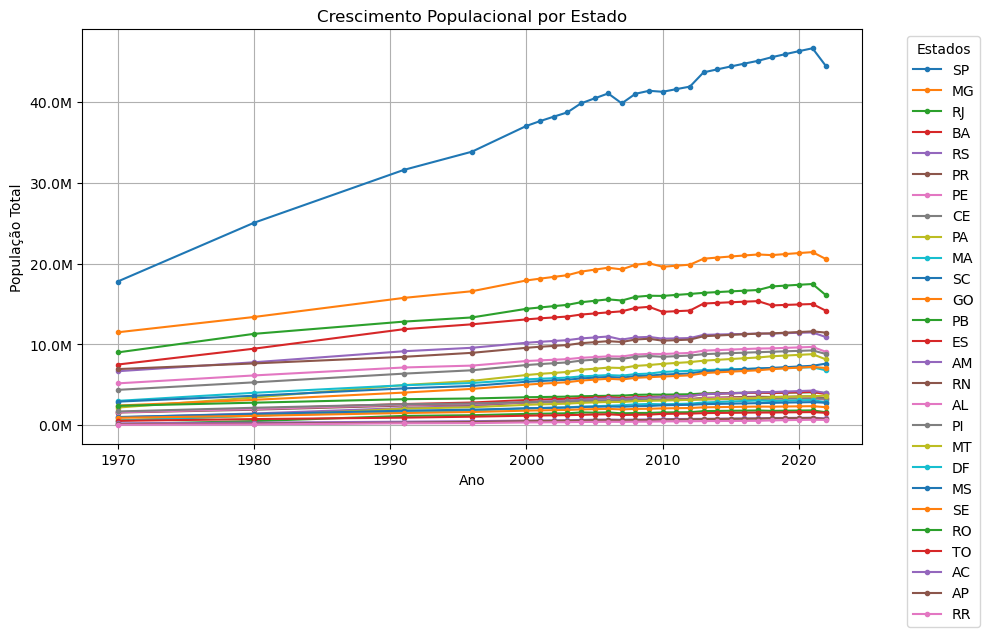

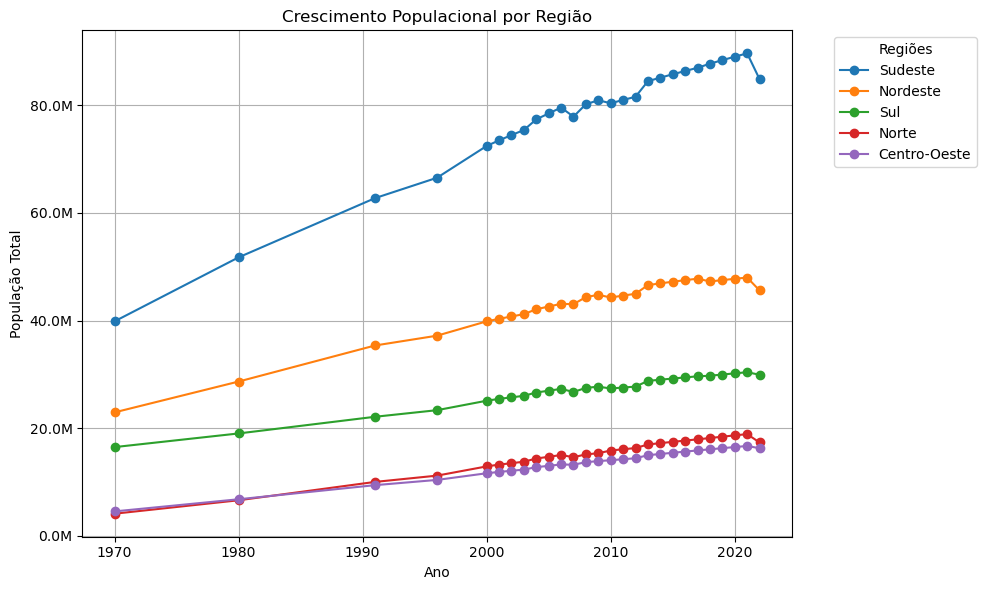

C:\Users\cleberson.nascimento\AppData\Local\Temp\ipykernel_9128\1302031739.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outliers_z['name_municipality'], y=outliers_z['z_score'], palette='coolwarm')


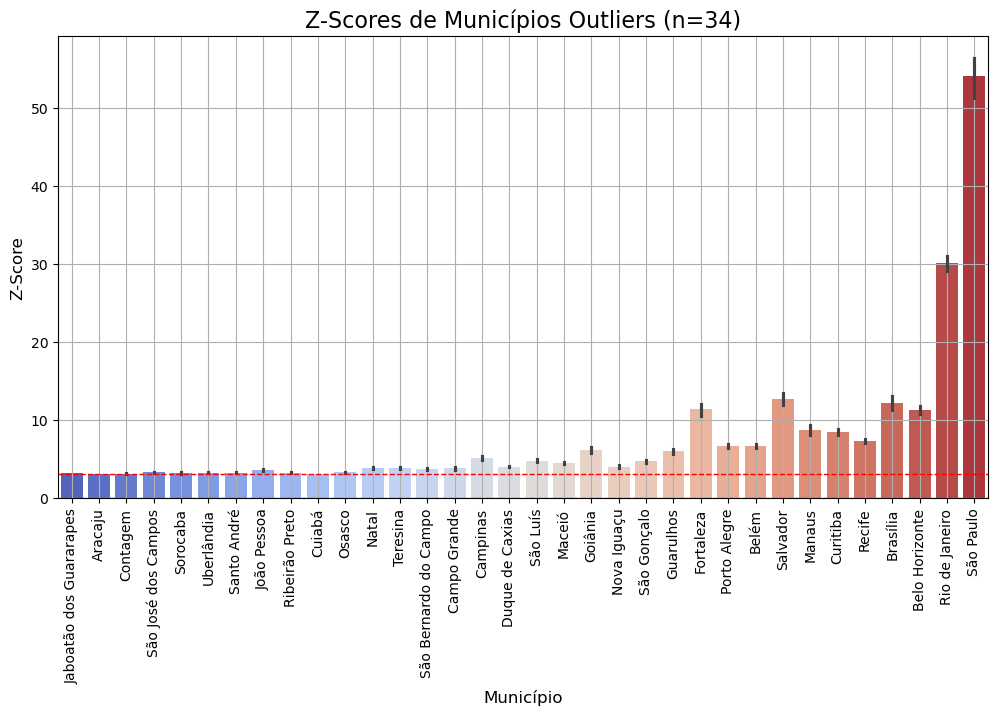

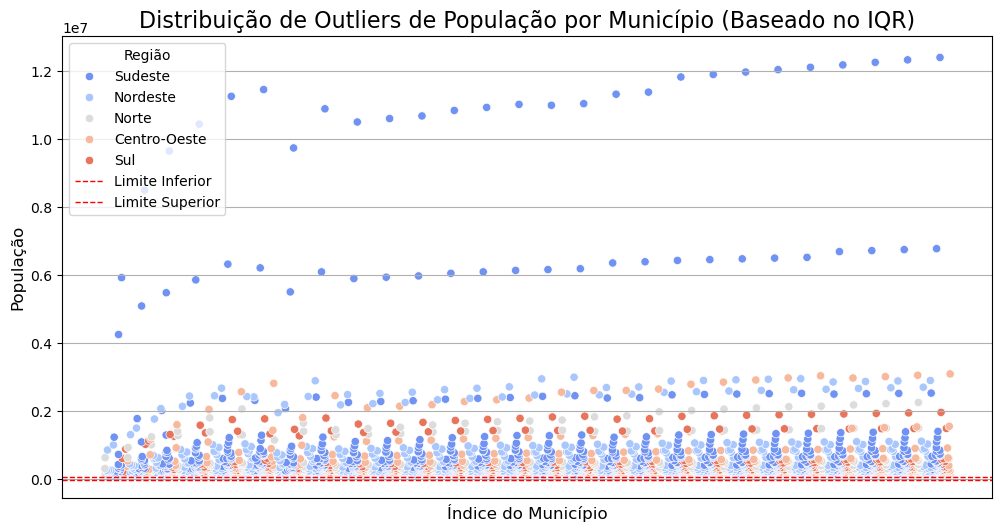

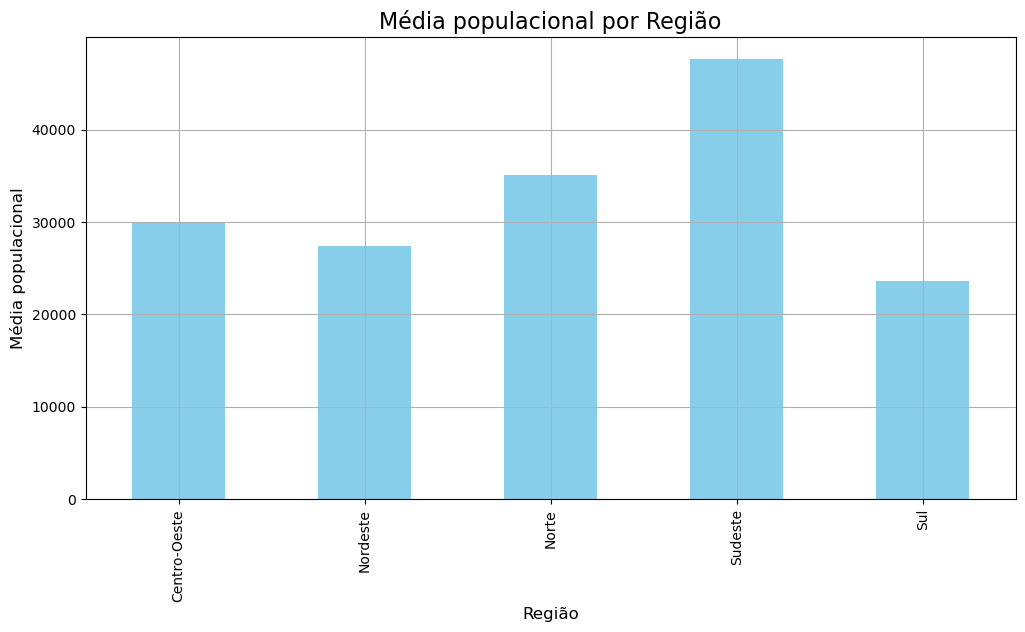

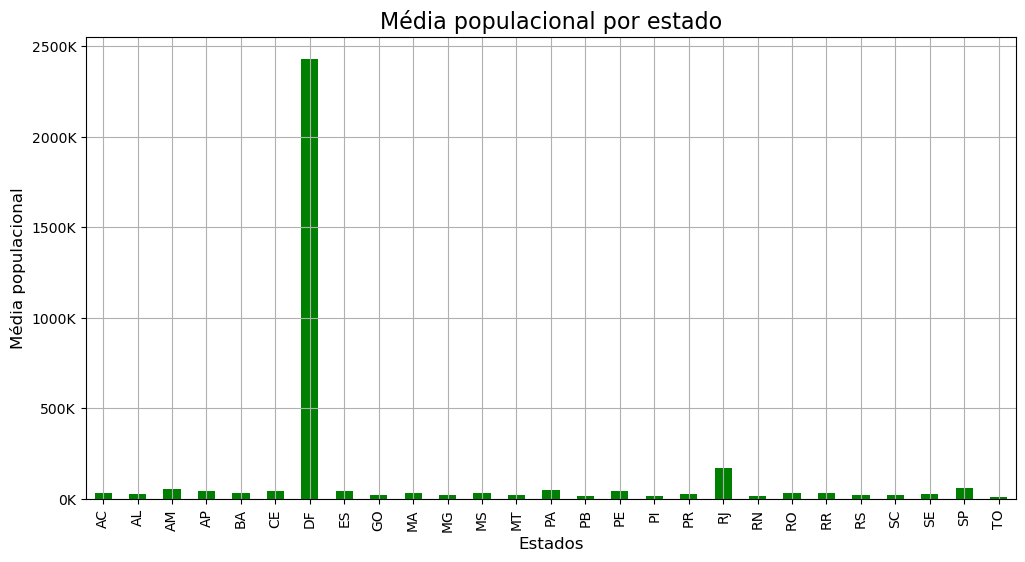

C:\Users\cleberson.nascimento\AppData\Local\Temp\ipykernel_9128\1026608570.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(proporcao_populacao_estado_sorted))


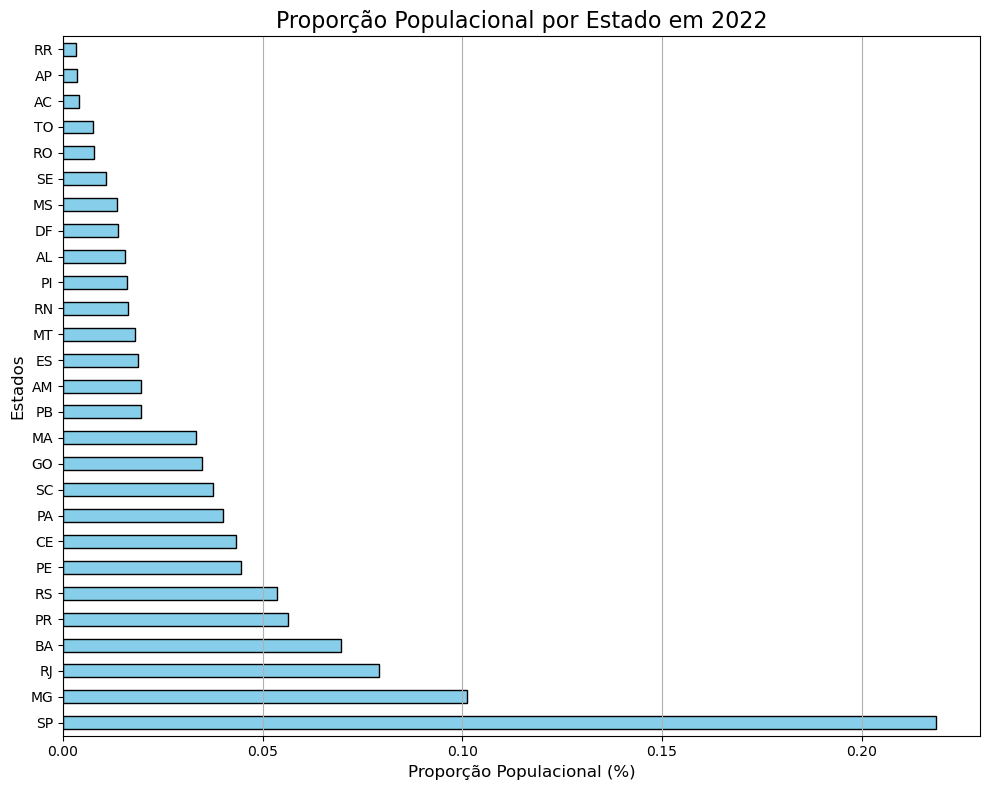

C:\Users\cleberson.nascimento\AppData\Local\Temp\ipykernel_9128\1974993635.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlacoes = dataframe.groupby('abbrev_state').apply(lambda x: x['year'].corr(x['population']))


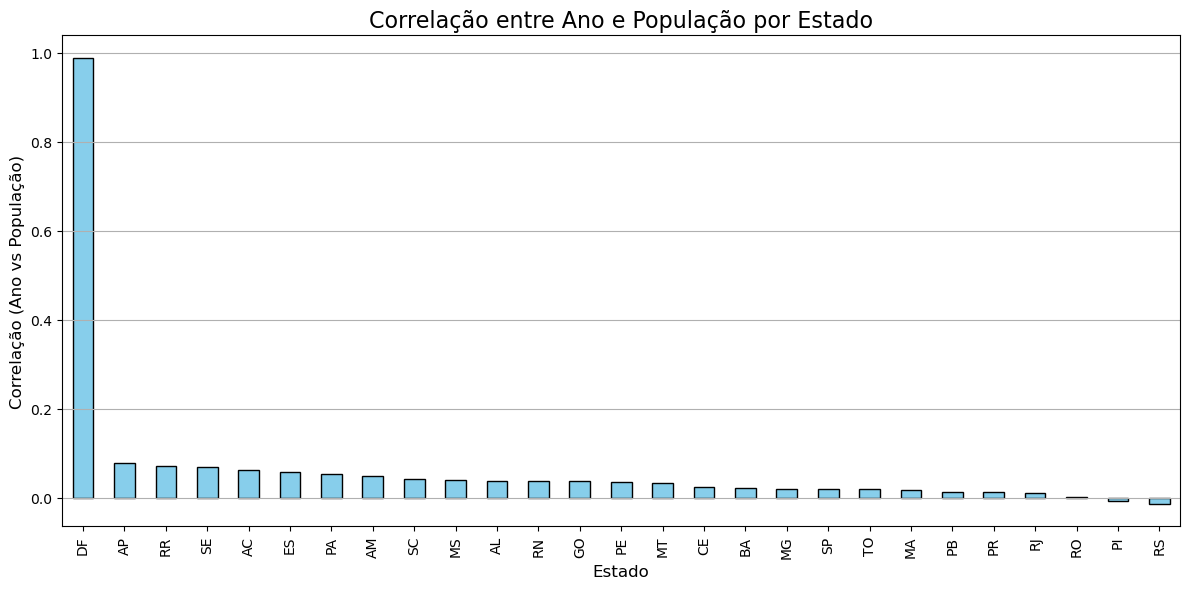

              correlacao
abbrev_state            
DF                  0.99
AP                  0.08
RR                  0.07
SE                  0.07
AC                  0.06
ES                  0.06
PA                  0.05
AM                  0.05
SC                  0.04
MS                  0.04
AL                  0.04
RN                  0.04
GO                  0.04
PE                  0.04
MT                  0.03
CE                  0.03
BA                  0.02
MG                  0.02
SP                  0.02
TO                  0.02
MA                  0.02
PB                  0.01
PR                  0.01
RJ                  0.01
RO                  0.00
PI                 -0.01
RS                 -0.01


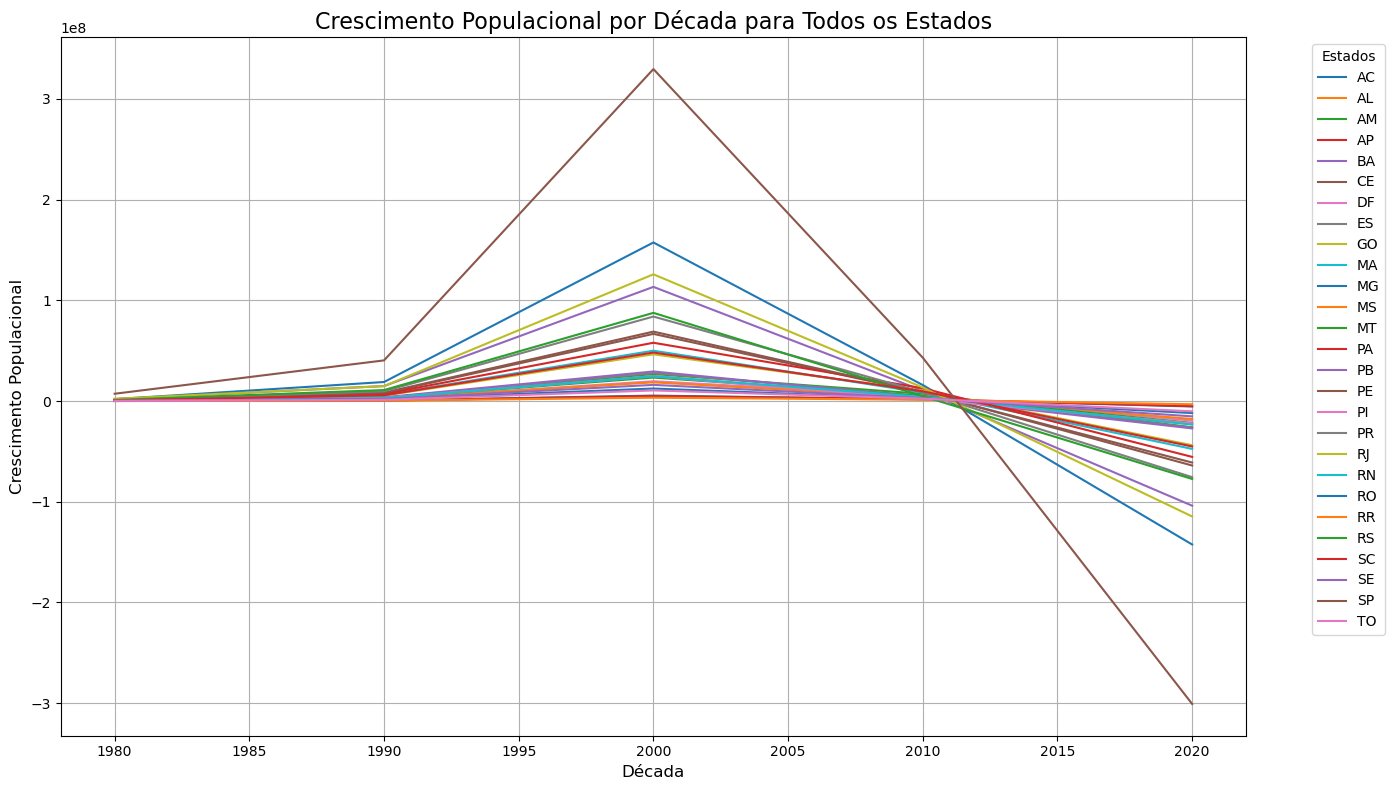

In [56]:
if __name__ == '__main__':
    main()